# DESaster Application Template
v. 050917

Features include Owner, Renter, Landlord, FinancialRecoveryProgram, TechnicalRecoveryProgram, Policies

## Required Modules

In [1]:
### External Modules
import sys, random, inspect
desaster_path = "/Users/geomando/Dropbox/github/DESaster"
sys.path.append(desaster_path)
import simpy
from simpy import Resource, Container, FilterStore
from simpy.util import start_delayed
import pandas as pd
import numpy as np
from scipy.stats import uniform, beta
import seaborn as sns
import matplotlib.pyplot as plt
import random

### DESaster Modules
from desaster.io import *
from desaster.structures import *
from desaster.financial import *
from desaster.technical import *
from desaster.entities import *
from desaster.policies import *
from desaster.distributions import *

# Set up renters assistance from FEMA and SBA...everything is pegged on entity.property and the amount of property damage, but renter needs to be about contents damage only. ***Started working on SBA_Loan by adding entity.contents_loss to calculation of loan amount.***

## Input Data
Input data must be MS Excel .xlsx file with format (column names and sheet names) of ../inputs/desaster_input_data_template.xlsx

In [2]:
scenario_file = '../inputs/desaster_input_data_template.xlsx'

__Create Pandas dataframe of attribute data for all owners to be modeled in the simulation.__

In [3]:
owners_df = pd.read_excel(scenario_file, sheetname='owners')
owners_df

,Name,Income,Owner Savings,Owner Insurance,Address,Monthly Cost,Occupancy,Bedrooms,Bathrooms,Area,Year Built,Value,Damage State,Listed,Longitude,Latitude,Owner Credit
0,Alfred,60000,100,0,62 That St,1482.755005,Mobile Home,1,1,1100,1920,306900,Complete,False,0,0,700
1,Bruce,1000000,100,1,720 This Rd,4043.877286,Single Family Dwelling,4,3,3000,1920,837000,Moderate,False,0,0,700
2,Selena,45000,100,0,1001 Other Ave,1010.969322,Single Family Dwelling,2,1,750,1960,209250,Extensive,False,0,0,700
3,Fish,125000,100,0,26000 Out There Lane,2695.918191,Single Family Dwelling,3,2,2000,2010,558000,Slight,False,0,0,700
4,Jerome,100000000,100000000,1,100 New Ave,1449.418382,Mobile Home,1,1,1100,1920,300000,None,True,0,0,700
5,Barbara,100000000,100000000,1,101 New Ave,3865.115686,Single Family Dwelling,4,3,3000,1920,800000,None,True,0,0,700
6,Lucius,100000000,100000000,1,102 New Ave,1449.418382,Single Family Dwelling,2,1,750,1960,300000,None,True,0,0,700
7,Dick,100000000,100000000,1,103 New Ave,2415.697304,Single Family Dwelling,3,2,2000,2010,500000,None,True,0,0,700


__Create Pandas dataframe of attribute data for all renters to be modeled in the simulation.__

In [4]:
renters_df = pd.read_excel(scenario_file, sheetname='renters')
renters_df

,Name,Address,Occupancy,Income,Tenant Savings,Tenant Credit,Tenant Insurance,Monthly Cost,Bedrooms,Bathrooms,...,Year Built,Value,Damage State,Landlord,Owner Savings,Owner Insurance,Listed,Longitude,Latitude,Owner Credit
0,Ivy,262 That St,Mobile Home,50000,1000,700,0,2480,1,1,...,1920,279000,Complete,Alice,0,0,False,0,0,700
1,Edward,4720 This Rd,Single Family Dwelling,1000000,1000,700,0,3720,3,2,...,1920,418500,Complete,Julie,0,0,False,0,0,700
2,Oswald,2301 Other Ave,Single Family Dwelling,25000,1000,700,0,1240,0,1,...,1960,139500,Complete,Gerry,0,1,False,0,0,700
3,James,74000 Out There Lane,Single Family Dwelling,100000,1000,700,0,4960,2,2,...,2010,558000,Complete,Sally,0,1,False,0,0,700
4,Butch,100 Old Ave,Mobile Home,100000000,1000,700,0,2480,1,1,...,1920,279000,None,Greg,100000000,1,True,0,0,700
5,Harvey,101 Old Ave,Single Family Dwelling,100000000,1000,700,0,3720,2,2,...,1920,418500,None,Allison,100000000,1,True,0,0,700
6,Lee,102 Old Ave,Mobile Home,100000000,1000,700,0,1240,0,1,...,1960,139500,None,Rachel,100000000,1,True,0,0,700
7,Carmine,103 Old Ave,Single Family Dwelling,100000000,1000,700,0,4960,3,2,...,2010,558000,None,Larry,100000000,1,True,0,0,700


## Setup the Simulaiton Environment and Populate with Entities and Processes

__Set Simpy simulation environment__

In [5]:
env = simpy.Environment()

__Indicate whether the simulation will keep track of the stories of each entity in the simulation. This can also be set individually for each group of imported entities (e.g., each call to an entities.Entity class or subclass.__

In [6]:
write_story = True

__Define the probability distributions that can/will be used in the simulation to define various recovery program process event durations.__

In [7]:
# A determistic scalar
scalar_dist = ProbabilityDistribution(dist='scalar', loc=10) 
# A determistic scalar for the repair program (which dynamically changes the distribution parameters)
repair_scalar_dist = ProbabilityDistribution(dist='scalar', loc=10) 
# A uniform distribution; min = loc, max = (loc + scale)
uni_dist = ProbabilityDistribution(dist='uniform', loc=5, scale=10) 
# A beta distribution; parameters define as numpy.stats.beta
beta_dist = ProbabilityDistribution(dist='beta', loc=5, scale=10, shape_a=2.0, shape_b=2.0)
# A weibull distribution; parameters define as numpy.stats.beta
wei_dist = ProbabilityDistribution(dist='weibull', loc=5, scale=10, shape_c=2.0)

sba_dist = DurationDistributionHomeLoanSBA(dist='scalar', loc=10) 
fema_scalar_dist = ProbabilityDistribution(dist='scalar', loc=10) 

__Instantiate the recovery program objects that will be used in the simulation. Each recovery program requires
specification of a duration probability distribution (set above). Unlike shown below, the distributions do not have to be the same for each program. Currently all are the same scalars to simplify interpretation and debugging.__

In [8]:
declaration = 30
sba_deadline = 60

fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration_distribution=fema_scalar_dist, max_outlay=30000,
                                  deadline=540, declaration_duration=declaration)
sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration_distribution=sba_dist, max_loan = 200000, 
                            min_credit = 600, deadline=sba_deadline, declaration_duration=declaration)
sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration_distribution=scalar_dist, 
                           max_loan = 2000000, deadline=sba_deadline, declaration_duration=declaration) # SBA max biz loan = $2mil
insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration_distribution=scalar_dist)
inspection = InspectionProgram(env, staff=1000, duration_distribution=scalar_dist)
assessment = EngineeringAssessment(env, staff=1000, duration_distribution=scalar_dist)
permitting = PermitProgram(env, staff=1000, duration_distribution=scalar_dist) 
repair = RepairProgram(env, staff=1000, materials=1000000000, duration_distribution=repair_scalar_dist)
demolition = DemolitionProgram(env, staff=1000, duration_distribution=scalar_dist)

In [9]:
#inspect.getfullargspec(rebuild_prog.process).args # Useful to determine the arguments for the recovery programs

__Instantiate any recovery policies. Policies are custom classes that define different recovery program arrangements, sequences, logic, patience, etc. Currently only one is written Insurance_IA_Loan_Sequential, which very loosely mimics FEMA's required sequencing of funding requests. The policy also provides an example of how to model entity "patience" and process interuption.__

In [10]:
insurance_ia_loan_seq = Insurance_IA_SBA_Sequential(env)
insurance_ia_loan_para = Insurance_IA_SBA_Parallel(env)
insurance_loan_seq = Insurance_SBA_Sequential(env)
insurance_loan_para = Insurance_SBA_Parallel(env)
repair_stock = RepairVacantBuilding(env)

__Create empty Simpy FilterStores to use as housing stocks.__

In [11]:
owned_stock = FilterStore(env)  # To put the residences associated with owners
rented_stock = FilterStore(env) # To put the residences associated with renters
# forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
# forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords

__Create a list of OwnerHousehold objects based on input data. Place each associated residence in the rented housing stock.__

In [12]:
owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)

__Create a list of RenterHousehold objects based on input data. Place each associated residence in the rented housing stock.__

In [13]:
renters = importEntities(env, renters_df, 'RenterHousehold', rented_stock, write_story)

__Create a list of Owner objects based on vacant for-sale housing data. Place each associated residence in the for sale housing stock.__

In [14]:
# owners_forsale = importEntities(env, forsale_stock, forsale_stock_df, 'Owner')

__Create a list of Owner objects based on vacant for-rent housing data. Place each associated residence in the for rent housing stock.__

In [15]:
# landlords_forrent = importEntities(env, forrent_stock, forrent_stock_df, 'Owner')

__A really basic custom master process to as an example of how to create one.__

In [16]:
def basic_process(inspection_program, assessment_program, permit_program, rebuild_program, entity):

        yield env.process(inspection_program.process(entity.property, entity))
        yield env.process(assessment_program.process(entity.property, entity))
        yield env.process(permit_program.process(entity.property, entity))
        yield env.process(rebuild_program.process(entity.property, entity))

__A custom master process for landlords. Landlords are the owners and so are the ones to seek financial assistance for repairs. If repairs can't be made etc., evict the tenants.__

In [17]:
def landlord_process(env, inspection_program, insurance_program, loan_program, 
                 assessment_program, permit_program, demolish_program, rebuild_program, entity):
    
    money_patience = 100000  # days until give up the search for rebuild money

    yield env.process(inspection_program.process(entity.property, entity))
    
    if entity.property.damage_state != 'None':
        
        
        # If home is completely damaged, evict tenant
        if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
            entity.tenant.prior_residences.append(entity.tenant.residence)
            entity.tenant.residence = None
            
            if entity.write_story == True:
                entity.tenant.story.append(
                '{0} was permanently evicted because the {1} had {2} damage. '.format(
                                                entity.tenant.name, entity.property.occupancy.lower(),
                                                entity.property.damage_state.lower()
                                                                                        )
                                            )

        # Landlord search for financial assistance

        yield env.process(insurance_loan_para.policy(insurance_program, loan_program, entity, money_patience))

        if entity.gave_up_funding_search != None:
            entity.tenant.prior_residences.append(entity.tenant.residence)
            entity.tenant.residence = None
            
            if entity.write_story == True:
                entity.tenant.story.append(
                '{0} was permanently evicted because the {1} was not repaired. '.format(
                entity.tenant.name, entity.property.occupancy.lower())
                )
                
                entity.story.append(
                '{0} decided not to repair their {1}. '.format(
                entity.name, entity.property.occupancy.lower()
                                                                )
                                    )
            return
        if entity.recovery_funds.level >= entity.property.damage_value:
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(rebuild_program.process(entity.property, entity))
        else:
            if entity.tenant.residence != None:
                entity.tenant.prior_residences.append(entity.tenant.residence)
                entity.tenant.residence = None

                if entity.write_story == True:
                    entity.tenant.story.append(
                    '{0} was permanently evicted because the {1} was not repaired. '.format(
                    entity.tenant.name, entity.property.occupancy.lower()
                                                                                            )
                                                )   

__A custom master process for OwnerHouseholds (owner occupiers). Don't do anything if no damage suffered. If residence damage is "Complete", abandon home and look to buy a different one. Otherwise look for financial assistance for repairs. If money for repairs can't be found (patience runs out), look for a new home. If home search patience runs out, simply stop.__

In [18]:
def owner_process(env, inspection_program, insurance_program, fema_program, loan_program, 
                 assessment_program, permit_program, demolish_program, rebuild_program, search_stock, entity):
    
    money_patience = 200000  # days until give up the search for rebuild money
    home_patience = 15000  # days until give up the search for a new home
    
    yield env.process(inspection_program.process(entity.property, entity))
    
    # Specify the event sequence for households from the time of the hazard through the decisions to relocate 
    # or rebuild
    if entity.property.damage_state != 'None':

        # If home is completely damaged, search for a new home to purchase.
#         if entity.property.damage_state == 'Complete':

#             yield env.process(entity.replace_home(search_stock, scalar_dist, down_payment_pct = 0.10,
#                                                   search_patience = home_patience)) 

#             if entity.gave_up_home_search == None:
#                 yield env.process(entity.occupy(duration_distribution = scalar_dist))

#             return
        
        # Search for financial assistance
        yield env.process(insurance_ia_loan_para.policy(insurance_program, fema_program,
                                                   loan_program, entity, money_patience))

        # If not enough money to repair home, search for a new home to purchase.
        if entity.recovery_funds.level < entity.property.damage_value:

            yield env.process(entity.replace_home(search_stock, scalar_dist, down_payment_pct = 0.10,
                                                  search_patience = home_patience))
            
            if entity.gave_up_home_search == None:
                yield env.process(entity.occupy(duration_distribution = scalar_dist))
            
            return
                
        elif entity.recovery_funds.level >= entity.property.damage_value:
            
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(rebuild_program.process(entity.property, entity))    
            yield env.process(entity.occupy(duration_distribution = scalar_dist))     

__A custom master process for RenterHouseholds. For the most part it simply initiates a process for their landlords. If they are evicted by their landlords, the renter will look for a new home. If home search patience runs out, simply stop. Otherwise, occupy home after landlord repairs it.__

In [19]:
def renter_process(env, inspection_program, renter_insurance, renter_ia, renter_loan, landlord_insurance, 
                   landlord_loan, assessment_program, permit_program, demolish_program, rebuild_program, 
                   search_stock, entity):
        
    money_patience = 365  # days until give up the search for rebuild money
    search_patience = 550  # days until give up the search for a new home
    
    if entity.residence.damage_state != 'None':
        yield env.process(landlord_process(env, inspection_program, landlord_insurance, 
                                landlord_loan, assessment_program, permit_program, demolish_program, 
                                rebuild_program, entity.landlord))

        
        if entity.residence != None:
            yield env.process(entity.occupy(duration_distribution = scalar_dist))
        else:

            yield env.process(entity.replace_home(search_stock, search_patience = search_patience))

            if not entity.gave_up_home_search:
                    yield env.process(entity.occupy(duration_distribution = scalar_dist))

__Initiate the master process for each owner to be modeled in the simulation.__

In [20]:
#inspect.getfullargspec(owner_process).args # Useful to determine what arguments are required for the process.

for i in range(len(owners)):
    env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i]))

__Initiate the master process for each renter to be modeled in the simulation.__

In [21]:
# # # #inspect.getfullargspec(renter_process).args # Useful to determine what arguments are required for the process.

# # sba_biz_loan specified because it is for the landlord, which can get an SBA business loan
# for i in range(len(renters)):
#     env.process(renter_process(env, inspection, insurance, fema_ia, sba_renter_loan, insurance, sba_biz_loan, 
#                                assessment, permitting, demolition, repair, rented_stock, renters[i]))

## Run the simulation

In [22]:
owners[0].fema_get

In [23]:
env.run()

276900.0 209461.240454 200000
0 3491020.67424 200000
63534.75 157095.930341 200000
0 436377.58428 200000
276900.0 209461.240454 200000
63534.75 157095.930341 200000
276900.0 209461.240454 200000
63534.75 157095.930341 200000


# Inspect Simulation Outputs

## OwnerHousehold summary statistics

In [24]:
num_damaged = 0
num_rebuilt = 0
num_gave_up_funding_search = 0
num_relocated = 0
num_homesearch = 0
num_gave_up_home_search = 0
num_vacant_fixed = 0

for household in owners:
    if household.residence.damage_state != None: num_damaged += 1
    if household.repair_get != None: num_rebuilt += 1
    if household.gave_up_funding_search: num_gave_up_funding_search += 1
    if household.home_put != None: num_homesearch += 1
    if household.home_get != None: num_relocated += 1
    if household.gave_up_home_search: num_gave_up_home_search += 1


        
print('{0} out of {1} owners suffered damage to their homes.\n'.format(num_damaged, len(owners)),
      '{0} out of {1} owners rebuilt or repaired their damaged home.\n'.format(num_rebuilt, len(owners)),
        '{0} out of {1} owners gave up searching for money.\n'.format(num_gave_up_funding_search, len(owners)),
      '{0} out of {1} owners searched for a new home.\n'.format(num_homesearch, len(owners)),
        '{0} out of {1} owners bought a new home.\n'.format(num_relocated, len(owners)),
        '{0} out of {1} owners gave up searching for a home.\n'.format(num_gave_up_home_search, len(owners))
     )



8 out of 8 owners suffered damage to their homes.
 3 out of 8 owners rebuilt or repaired their damaged home.
 0 out of 8 owners gave up searching for money.
 1 out of 8 owners searched for a new home.
 1 out of 8 owners bought a new home.
 0 out of 8 owners gave up searching for a home.



## Print OwnerHousehold stories

In [25]:
owners[0].story

['Alfred resides at 62 That St. ',
 'Alfred owns and lives in a 1 room mobile home at 62 That St worth $306,900. ',
 "Alfred's mobile home was inspected 10 days after the event and suffered $306,900 of damage (complete). ",
 'Alfred has no hazard insurance. ',
 'Alfred applied for a $200,000 SBA loan 30 days after the event.',
 'Alfred requested $30,000 from FEMA 30 days after the event. ',
 'Alfred received $30,000 from FEMA 40 days after the event. ',
 "SBA inspected Alfred's home on day 41 after the event. ",
 'Alfred received an initial SBA loan disbursement of $25,000 41 days after the event. ',
 'Alfred received a second SBA loan disbursement of $175,000 51 days after the event. ',
 'It took Alfred 21 days to exhaust financial assistance options but still does not have enough money to cover repairs ($230,100). ',
 'Alfred started searching for a new mobile home 51 days after the event. ',
 'On day 61, Alfred purchased a mobile home at 100 New Ave with a value of $300,000. ',
 'Al

In [26]:
owners[1].story

['Bruce resides at 720 This Rd. ',
 'Bruce owns and lives in a 4 room single family dwelling at 720 This Rd worth $837,000. ',
 "Bruce's single family dwelling was inspected 10 days after the event and suffered $83,700 of damage (moderate). ",
 'Bruce submitted an insurance claim 10 days after the event. ',
 'Bruce received a $83,700 insurance payout 20 days after the event. ',
 'Bruce requested $30,000 from FEMA 30 days after the event. ',
 'Bruce withdrew their application to FEMA 40 days after the event because enough recovery funds were found from other sources. ',
 'It took Bruce 30 days to exhaust financial assistance options and now has $83,800 for repairs. ',
 'Bruce received an engineering assessment 50 days after the event. ',
 'Bruce received permit approval 60 days after the event. ',
 "Bruce's single family dwelling was repaired 62 days after the event, taking 2 days to rebuild. ",
 'Bruce occupied the single family dwelling 72 days after the event. ']

In [27]:
owners[2].story

['Selena resides at 1001 Other Ave. ',
 'Selena owns and lives in a 2 room single family dwelling at 1001 Other Ave worth $209,250. ',
 "Selena's single family dwelling was inspected 10 days after the event and suffered $93,535 of damage (extensive). ",
 'Selena has no hazard insurance. ',
 'Selena applied for a $63,535 SBA loan 30 days after the event.',
 'Selena requested $30,000 from FEMA 30 days after the event. ',
 'Selena received $30,000 from FEMA 40 days after the event. ',
 "SBA inspected Selena's home on day 41 after the event. ",
 'Selena received an initial SBA loan disbursement of $25,000 41 days after the event. ',
 'Selena received a second SBA loan disbursement of $38,535 51 days after the event. ',
 'It took Selena 21 days to exhaust financial assistance options and now has $93,635 for repairs. ',
 'Selena received an engineering assessment 61 days after the event. ',
 'Selena received permit approval 71 days after the event. ',
 "Selena's single family dwelling was de

In [28]:
owners[3].story

['Fish resides at 26000 Out There Lane. ',
 'Fish owns and lives in a 3 room single family dwelling at 26000 Out There Lane worth $558,000. ',
 "Fish's single family dwelling was inspected 10 days after the event and suffered $11,160 of damage (slight). ",
 'Fish has no hazard insurance. ',
 'Fish requested $11,160 from FEMA 30 days after the event. ',
 'Fish received $11,160 from FEMA 40 days after the event. ',
 'It took Fish 10 days to exhaust financial assistance options and now has $11,260 for repairs. ',
 'Fish received an engineering assessment 50 days after the event. ',
 'Fish received permit approval 60 days after the event. ',
 "Fish's single family dwelling was repaired 62 days after the event, taking 2 days to rebuild. ",
 'Fish occupied the single family dwelling 72 days after the event. ']

## RenterHousehold summary statistics

In [29]:
num_damaged = 0
num_rebuilt = 0
num_relocated = 0
num_displaced = 0
num_gave_up_funding_search = 0
num_gave_up_home_search = 0
num_vacant_fixed = 0

for renter in renters:

    if renter.landlord.property.damage_state != None: num_damaged += 1
    if renter.landlord.repair_get != None: num_rebuilt += 1
    if renter.landlord.gave_up_funding_search != None: num_gave_up_funding_search += 1
    if not renter.residence: num_displaced += 1
    if renter.gave_up_home_search: num_displaced += 1


        
print('{0} out of {1} renters\' homes suffered damage.\n'.format(num_damaged, len(renters)),
      '{0} out of {1} renters\' damaged home was rebuilt or repaired.\n'.format(num_rebuilt, len(renters)),
      '{0} out of {1} renters\' were displaced.\n'.format(num_displaced, len(renters)),
      '{0} landlords gave up searching for repair money.\n'.format(num_gave_up_funding_search)
     )

8 out of 8 renters' homes suffered damage.
 0 out of 8 renters' damaged home was rebuilt or repaired.
 0 out of 8 renters' were displaced.
 0 landlords gave up searching for repair money.



In [30]:
# for lessor in landlords_forrent:
#     if lessor.property.damage_state_start != lessor.property.damage_state:
#         num_vacant_fixed += 1
        
# print(
#       '{0} of {1} vacant rental homes were repaired and returned to the vacant rental stock.'.format(num_vacant_fixed,
#                                                                                                      len(landlords_forrent))
#       )

## Print RenterHousehold stories

In [31]:
renters[0].story + renters[0].landlord.story

['Ivy resides at 262 That St. ',
 'Ivy rents and lives in a 1 room mobile home at 262 That St. ',
 'Alice rents out a 1 bedroom mobile home at 262 That St worth $279,000. ']

In [32]:
renters[1].story + renters[1].landlord.story

['Edward resides at 4720 This Rd. ',
 'Edward rents and lives in a 3 room single family dwelling at 4720 This Rd. ',
 'Julie rents out a 3 bedroom single family dwelling at 4720 This Rd worth $418,500. ']

In [33]:
renters[2].story + renters[2].landlord.story

['Oswald resides at 2301 Other Ave. ',
 'Oswald rents and lives in a 0 room single family dwelling at 2301 Other Ave. ',
 'Gerry rents out a 0 bedroom single family dwelling at 2301 Other Ave worth $139,500. ']

In [34]:
renters[3].story + renters[3].landlord.story

['James resides at 74000 Out There Lane. ',
 'James rents and lives in a 2 room single family dwelling at 74000 Out There Lane. ',
 'Sally rents out a 2 bedroom single family dwelling at 74000 Out There Lane worth $558,000. ']

__*** This works but is a bandaid for saving simulation outputs for external visualization or stats. *** Create output file for visualizing__

In [35]:
a = list(vars(owners[3]).keys()) #gets all potential column names
a.extend(list(vars(owners[3].property).keys()))
df = pd.DataFrame(columns=a)
iters = 0
att_itter = 0
new_column={}
log = []
for i in owners: #loop through all entities
    i.story = i.story_to_text()
#     i.latitude = i.residence.latitude
#     i.longitude = i.residence.longitude
#     i.gave_up_funding_search = int(i.gave_up_funding_search)
#     i.gave_up_home_search = int(i.gave_up_home_search)
    i.damage_state_start = i.residence.damage_state_start
    i.damage_state = i.residence.damage_state
    i.damage_value = i.residence.damage_value
    i.damage_value_start = i.residence.damage_value_start
    for att in a: #loop through the attributes in our list of column names we want
        try:
            new_column[att] = i.__getattribute__(att) #set the b dictionary
            #mydata[att]= i.__getattribute__(att)
            
        except ValueError:
            new_column[att] = np.nan
        except AttributeError as e:
            new_column[att] = np.nan
            log.append("Household {0} had an attr error, {1}".format(i.name, e))
        finally:
            att_itter += 1
    mydata=pd.DataFrame([new_column]) #this turns our newly made column into a database where it can be combined with the df

    df = df.append(mydata, ignore_index=True)

    iters += 1

# output_path = "../outputs/output_df.csv"
# df.to_csv(output_path)
df.head()

,address,area,assessment,assessment_get,assessment_put,assistance_payout,bathrooms,bedrooms,claim_amount,claim_get,...,repair_put,residence,savings,sba_amount,sba_get,sba_put,stock,story,value,write_story
0,NaN,NaN,NaN,None,None,0.0,NaN,NaN,0.0,None,...,None,<desaster.structures.SingleFamilyResidential o...,100.0,200000.00,51,30,NaN,Alfred resides at 62 That St. Alfred owns and ...,NaN,True
1,NaN,NaN,NaN,50,40,0.0,NaN,NaN,83700.0,20,...,None,<desaster.structures.SingleFamilyResidential o...,100.0,0.00,None,30,NaN,Bruce resides at 720 This Rd. Bruce owns and l...,NaN,True
2,NaN,NaN,NaN,61,51,0.0,NaN,NaN,0.0,None,...,None,<desaster.structures.SingleFamilyResidential o...,100.0,63534.75,51,30,NaN,Selena resides at 1001 Other Ave. Selena owns ...,NaN,True
3,NaN,NaN,NaN,50,40,0.0,NaN,NaN,0.0,None,...,None,<desaster.structures.SingleFamilyResidential o...,100.0,0.00,None,30,NaN,Fish resides at 26000 Out There Lane. Fish own...,NaN,True
4,NaN,NaN,NaN,None,None,0.0,NaN,NaN,0.0,None,...,None,<desaster.structures.SingleFamilyResidential o...,100000000.0,0.00,None,None,NaN,Jerome resides at 100 New Ave. Jerome owns and...,NaN,True


In [36]:
event_list=[]


for i in df.columns:
    if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
        event_list.append(i)

event_df = df[event_list]
event_df = event_df.set_index('name')
event_df

,assessment_get,assessment_put,claim_get,claim_put,damage_state_start,damage_value_start,demolition_get,demolition_put,fema_get,fema_put,...,inspection_put,occupy_get,occupy_put,permit_get,permit_put,rebuild_put,repair_get,repair_put,sba_get,sba_put
name,,,,,,,,,,,,,,,,,,,,,
Alfred,None,None,None,None,None,0.00,None,None,40,30,...,0.0,71,61,None,None,NaN,None,None,51,30
Bruce,50,40,20,10,Moderate,83700.00,None,None,None,30,...,0.0,72,62,60,50,60.0,62,None,None,30
Selena,61,51,None,None,Extensive,93534.75,81,71,40,30,...,0.0,271,261,71,61,81.0,261,None,51,30
Fish,50,40,None,None,Slight,11160.00,None,None,40,30,...,0.0,72,62,60,50,60.0,62,None,None,30
Jerome,None,None,None,None,None,0.00,None,None,None,None,...,0.0,None,None,None,None,NaN,None,None,None,None
Barbara,None,None,None,None,None,0.00,None,None,None,None,...,0.0,None,None,None,None,NaN,None,None,None,None
Lucius,None,None,None,None,None,0.00,None,None,None,None,...,0.0,None,None,None,None,NaN,None,None,None,None
Dick,None,None,None,None,None,0.00,None,None,None,None,...,0.0,None,None,None,None,NaN,None,None,None,None


__Example of how to visualize individual entities.__

[<matplotlib.text.Text at 0x114ef89e8>, <matplotlib.text.Text at 0x114ee9198>]

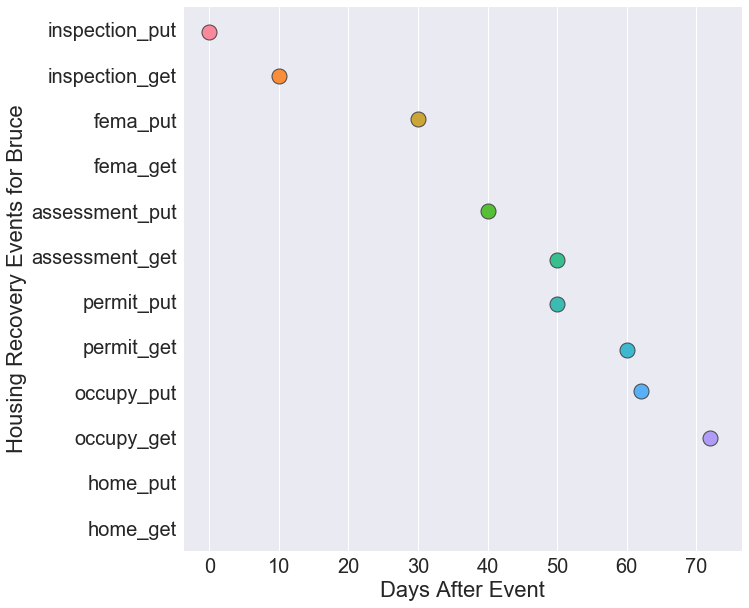

In [37]:
name = "Bruce"

name_row = df[df['name']==name][['inspection_put',
 'inspection_get',
 'fema_put',
 'fema_get',
 'assessment_put',
 'assessment_get',
 'permit_put',
 'permit_get',
'occupy_put',
'occupy_get',
 'home_put',
 'home_get']]

%matplotlib inline
plt.figure(figsize=(10,10))
sns.set_style(style="whitegrid")
sns.set(font_scale=2)
ax = sns.stripplot(name_row.iloc[0], name_row.columns, jitter=True, size = 15, linewidth=1)
ax.set(xlabel="Days After Event", ylabel="Housing Recovery Events for {0}".format(name))

In [38]:
name_row

,inspection_put,inspection_get,fema_put,fema_get,assessment_put,assessment_get,permit_put,permit_get,occupy_put,occupy_get,home_put,home_get
1,0.0,10.0,30,None,40,50,50,60,62,72,None,None


In [39]:
# f, ax = plt.subplots(1, figsize=(16, 6))
# df["home_get"].plot(kind='hist', bins=10, title='Number of Homes Repaired Over Time', figsize=(10,6), fontsize=14)
# plt.xlabel('Days After Earthquake', fontsize=16)
# plt.ylabel('Count', fontsize=16)

# for container in ax.containers:
#               plt.setp(container, width=1)        

In [40]:
# f, ax = plt.subplots(1, figsize=(16, 6))
# sns.boxplot(data=df[['inspection_get', 'claim_get', 'assistance_get', 'sba_get', 
#                       'assessment_get', 'permit_get', 'home_get']], ax=ax)
# plt.xlabel('Event', fontsize=16)
# plt.ylabel('Event Duration (Days)', fontsize=16)
# plt.xticks(fontsize=12)
# plt.title('Time Distributions For Housing Recovey Simulation Events')

# ax.tick_params(labelsize=16)

In [41]:
# f, ax = plt.subplots(1, figsize=(16, 6))

# order = ['None', 'Slight', 'Moderate','Extensive','Complete']

# df_damage_state = df[['home_get', 'damage_state_start']].groupby('damage_state_start')

# df_damage_state_mean = df_damage_state.mean().ix[order]

# df_damage_state_mean.plot(kind='bar', rot=0, legend=False, ax=ax)

# plt.xlabel('Damage State', fontsize=16)
# plt.ylabel('Days After Earthquake', fontsize=16)
# plt.xticks(fontsize=12)
# plt.title('Mean Time To Repair Home vs. Damage State')

# ax.tick_params(labelsize=16)